In [1]:
import sys
sys.path.append("/data/modules/")

In [16]:
import VoVNet_pytorch.models_vovnet as vovModels
import torch

In [5]:
vov57_path = "/data/modules/VoVNet_pytorch/pretrained/vovnet57_torchvision.pth"

In [17]:
# functions from from vov_models

def vovnet57(pretrained=False, progress=True, **kwargs):
    r"""Constructs a VoVNet-57 model as described in 
    `"An Energy and GPU-Computation Efficient Backbone Networks"
    <https://arxiv.org/abs/1904.09730>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vovnet('vovnet57', [128, 160, 192, 224], [256, 512, 768, 1024],
[1,1,4,3], 5, pretrained, progress, **kwargs)


def _vovnet(arch,
            config_stage_ch,
            config_concat_ch,
            block_per_stage,
            layer_per_block,
            pretrained,
            progress,
            **kwargs):
    model = vovModels.VoVNet(config_stage_ch, config_concat_ch,
                   block_per_stage, layer_per_block,
                   **kwargs)
    if pretrained:
#         state_dict = load_state_dict_from_url(model_urls[arch],
#                                               progress=progress)
        state_dict = torch.load(vov57_path)
        # strip "module." off the start of each key. for some reason it has this?
        state_dict = {k.lstrip("module."): v for k,v in state_dict.items()}
        

        model.load_state_dict(state_dict)
    return model

In [115]:
vov_model = vovnet57(pretrained=True)

In [116]:
vov_model

VoVNet(
  (stem): Sequential(
    (stem_1/conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (stem_1/norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stem_1/relu): ReLU(inplace)
    (stem_2/conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (stem_2/norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stem_2/relu): ReLU(inplace)
    (stem_3/conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (stem_3/norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stem_3/relu): ReLU(inplace)
  )
  (stage2): _OSA_stage(
    (OSA2_1): _OSA_module(
      (layers): ModuleList(
        (0): Sequential(
          (OSA2_1_0/conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (OSA2_1_0/norm): BatchNorm2d(128, eps=1e-05, momentum=0.1

# load data

In [27]:
import skimage
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
import numpy as np
import itertools
import torchvision
import PIL


%matplotlib inline

/home/adam/.local/share/virtualenvs/data-I7nS9QO2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/adam/.local/share/virtualenvs/data-I7nS9QO2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/adam/.local/share/virtualenvs/data-I7nS9QO2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [28]:
video_path = "/data/aicity/train/2.mp4"

In [29]:
def load_video(filename):
    # Loads a video with opencv, returns PIL Images for each frame
    
    vid = cv.VideoCapture(filename)

    while vid.isOpened():
        has_frame, img = vid.read()

        if has_frame:
            yield PIL.Image.fromarray(img[:,:,::-1])
        else:
            break

In [30]:
vid = load_video(video_path)

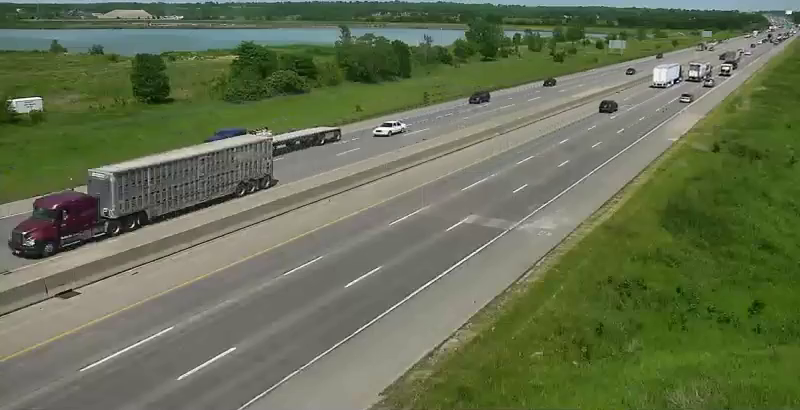

In [31]:
lq_img = next(vid)
lq_img

In [32]:
def transform_shrink_pad(img_shape, new_shape):
    """
    Resizes an image to fit in new_shape, preserving aspect ratio.
    Pads the rest (bottom or right) with 0s.
    
    """
    
    img_shape = np.array(img_shape)
    new_shape = np.array(new_shape)
    
    scale = (img_shape / new_shape).max() # Find which axis to scale by
    
    actual_new_shape = (img_shape / scale).astype(int)
    padding = new_shape - actual_new_shape
    
#     print(img_shape, new_shape, scale, actual_new_shape, padding)
    
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(actual_new_shape[::-1]),
        torchvision.transforms.Pad((0, 0, *padding))
    ])

def get_scale_factors(img_shape, new_shape):
    scales = img_shape / new_shape
    actual_new_shape = (img_shape / scales.max()).astype(int)
    padding = new_shape - actual_new_shape
    
    return scales, actual_new_shape, padding

def transform_unpad_grow(original_shape, shrunk_shape, scales, actual_new_shape, padding):
    return torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda img: img[:actual_new_shape[0], :actual_new_shape[1],]),# crop off padding
        torchvision.transforms.Resize(original_shape)
    ])

In [33]:
class VideoDataset(torch.utils.data.Dataset):
    """ Any .mp4 video should work """
    
    def __init__(self, video_filename, transform=None):
        self.video_filename = video_filename
        self.transform = transform
        
        # Open video
        self.cap = cv.VideoCapture(video_filename)
        
        # Length of video
        self.nframes = int(self.cap.get(cv.CAP_PROP_FRAME_COUNT))
        
    def __len__(self):
        return self.nframes
        
    def __getitem__(self, idx):
        """ Reads a frame, returning a PIL Image """
        
        # Make sure the index is valid
        if not (0 <= idx < self.nframes):
            raise IndexError(f"Index out of bounds: {idx} not in [0, {self.nframes})")
        
        
        self.cap.set(cv.CAP_PROP_POS_FRAMES, idx) # set position in video
        
        _, frame = self.cap.read()
        img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        img = PIL.Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)
        
        return img, idx

class VideoDatasetTensor(VideoDataset):
    """ Wrapper for VideoDataset. Returns images as tensors """
    
    
    def __init__(self, video_filename, transform=None):
        super().__init__(video_filename, transform)
        
    def __getitem__(self, idx):
        img, idx = super().__getitem__(idx)
        return torchvision.transforms.ToTensor()(img), idx
        

In [272]:
vid_dataset = VideoDatasetTensor(video_path, transform=torchvision.transforms.RandomCrop(300))
# vid_dataset = VideoDatasetTensor(video_path)
vid_data_loader = torch.utils.data.DataLoader(vid_dataset, shuffle=False,  batch_size=1, num_workers=0)

---
# Model stuff

In [205]:
with torch.no_grad():
    for data, idx in vid_data_loader:
        res = vov_model(data)
        break

In [200]:
res

tensor([[-8.3733e-01, -3.9532e-01, -5.8811e-01, -1.0581e+00, -7.5316e-01,
         -3.4714e-01, -7.0661e-01,  3.5098e-01,  2.7417e-01, -6.0962e-01,
         -6.1848e-01, -7.5088e-01, -6.4075e-01, -8.9226e-01, -1.0582e+00,
         -3.7726e-01, -7.9768e-01, -3.3629e-01, -2.6925e-01, -4.6229e-01,
         -7.1674e-01, -5.7190e-01, -1.1262e+00, -7.7524e-02, -7.8363e-01,
         -9.0742e-01, -7.2534e-01, -6.1692e-01, -5.0525e-01, -5.0219e-01,
         -7.7125e-01, -7.4973e-01, -5.7383e-01, -4.8333e-01, -2.6929e-01,
         -7.3766e-01,  5.6491e-01, -4.3133e-01, -6.0114e-01,  1.7977e-01,
         -5.1197e-01, -4.1585e-01, -6.4023e-01, -2.5929e-01, -2.9563e-01,
         -2.2339e-01, -4.6515e-01, -5.1032e-01, -1.0160e+00, -6.9919e-01,
         -6.0287e-01,  1.1745e-01, -3.3414e-02, -3.2749e-01, -5.0191e-01,
         -8.5217e-01, -5.4762e-01, -8.6798e-01, -4.4822e-01, -3.2578e-02,
          6.7882e-01, -1.5536e-01, -1.0076e-01, -2.7107e-01, -3.8366e-01,
         -4.4492e-01, -2.8641e-01, -3.

In [40]:
res.shape

torch.Size([1, 1000])

# Using vovnet backbone for SSD

In [53]:
import torch.nn as nn

In [261]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples', 'nvidia_ssd', model_math=precision)

Using cache found in /home/adam/.cache/torch/hub/NVIDIA_DeepLearningExamples_master


In [223]:
# vov_model
vov_net = nn.Sequential(*list(vov_model.children())[:-1]) # take out classifier layer
vov_net

Sequential(
  (0): Sequential(
    (stem_1/conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (stem_1/norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stem_1/relu): ReLU(inplace)
    (stem_2/conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (stem_2/norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stem_2/relu): ReLU(inplace)
    (stem_3/conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (stem_3/norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stem_3/relu): ReLU(inplace)
  )
  (1): _OSA_stage(
    (OSA2_1): _OSA_module(
      (layers): ModuleList(
        (0): Sequential(
          (OSA2_1_0/conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (OSA2_1_0/norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [262]:
# ssd_model.feature_extractor # resnet component
ssd_model

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
  

## Messing with vovnet arch

In [273]:
for data, idx in vid_data_loader:
    break

In [274]:
data.shape

torch.Size([1, 3, 300, 300])

In [275]:
ssd_model.feature_extractor(data).shape

torch.Size([1, 1024, 38, 38])

In [264]:
vov_net(data).shape

torch.Size([1, 1024, 12, 25])

In [287]:
with torch.no_grad():
    res_vov = vov_net_resnet_replacement(data)

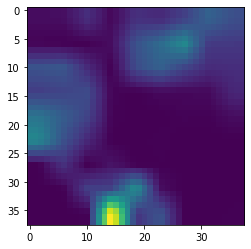

In [288]:
plt.imshow(res_vov.cpu().numpy()[0, 3, :, :])

In [285]:
vov_net_resnet_replacement = nn.Sequential(vov_net, torch.nn.Upsample(size=(38, 38), mode='bilinear'))

In [286]:
vov_net_resnet_replacement(data).shape

/home/adam/.local/share/virtualenvs/data-I7nS9QO2/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 1024, 38, 38])

In [281]:
with torch.no_grad():
    res_ssd = ssd_model.feature_extractor(data)

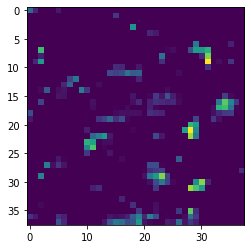

In [289]:
plt.imshow(res_ssd.cpu().numpy()[0, 486, :, :])

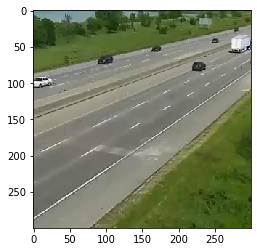

In [290]:
plt.imshow(data.cpu().numpy()[0].transpose((1,2,0)))

In [291]:
ssd_model.feature_extractor = vov_net_resnet_replacement

In [292]:
with torch.no_grad():
    res = ssd_model(data)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

In [260]:
res[0].shape

torch.Size([1, 4, 31424])

In [210]:
res[1].shape

torch.Size([1, 81, 16316])

In [193]:
for r in res:
    print(r)
    r.float()

tensor([[[ 1.0038,  0.1528,  0.1445,  ..., -1.8976,  3.3441,  0.0671],
         [ 0.6679,  1.4023,  1.1926,  ...,  0.0196, -0.1358, -0.1101],
         [-2.9139, -1.1316, -0.3923,  ...,  0.1403, -0.5040,  0.2363],
         [-2.9209, -2.2616, -2.3942,  ..., -0.4022, -0.2852, -0.2265]]])
tensor([[[ 9.2919,  9.4615,  9.3504,  ...,  7.7427,  7.1951,  2.1538],
         [ 4.0747,  5.1530,  5.3204,  ...,  3.9663,  3.1199,  3.9600],
         [-0.1796,  0.3607,  0.8950,  ..., -0.2143, -0.1227, -1.0626],
         ...,
         [-0.7515, -0.8279, -0.8573,  ...,  2.6586,  3.4905,  3.6538],
         [-0.9723, -1.1700, -1.0776,  ..., -1.4278, -1.5436, -1.5509],
         [-0.4921, -0.8262, -0.8606,  ..., -0.9088, -0.9670, -0.7430]]])


In [194]:
# load util functions
utils = torch.hub.load('NVIDIA/DeepLearningExamples', 'nvidia_ssd_processing_utils')

Using cache found in /home/adam/.cache/torch/hub/NVIDIA_DeepLearningExamples_master


In [195]:
utils.decode_results(res)

RuntimeError: The size of tensor a (31424) must match the size of tensor b (8732) at non-singleton dimension 1